# Supervised Classification using TabNet

In this notebook, we will see how to use the TabNet layers from this repository to build a supervised learning classifier in TF Keras. As an example, we will analyze the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/adult). The goal here is to predict the income bracket (earns <=\$50K or >50K) of an individual based on some descriptive features (e.g., age, sex, race, marital status, occupation, capital gain/loss, etc.).

In [1]:
import sys 
sys.path.append("../")

# import torch
# import pandas as pd
import plotly.express as px
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
from utils.load_data import get_datasets_np
# from pytorch_tabnet.tab_model import TabNetClassifier

from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from category_encoders.woe import WOEEncoder
# from sklearn.compose import ColumnTransformer
from tensorflow.keras import metrics

from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

from tensorflow_addons.activations import sparsemax
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If

## Loading and preparing data
We load the Adult Census Income dataset from the UCI data repository. We impute the missing values with the mode value. We encode the labels into binary. Finally, we convert the data into [TF Dataset format](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [2]:
x,y, class_weights = get_datasets_np()


#'time', 'age', 'gender_f', 'gender_m'
time = ['time']
vital = ['rr','hr','spo2','sbp','dbp','temp']
CBC = ['hct','hb','platelets','wbc','rbc','mch','mchc','mcv']
ABGA = ['ph','hco3', 'po2','pco2','sao2','fio2','pfratio']
time_series = time+vital+CBC+ABGA
info = ['age', 'gender_f', 'gender_m']
scores = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'QSofa']
name = time_series+info+scores

def flatten_name(name, N):
    return [name[i] + '_' + str(j) for i in range(len(name)) for j in range(1, N+1)]

def flatten_ts(X):
    X_ts  =X[:,:,:-8]
    X_static = X[:,0,-8:-6] #exclude gender_m
    X_score = X[:,:,-5:]
    flat_x_ts = np.transpose(X_ts, (0, 2, 1)).reshape(X_ts.shape[0], -1)
    datasets_score = np.transpose(X_score, (0, 2, 1)).reshape(X_score.shape[0], -1)
    flatten_x = np.concatenate((flat_x_ts, X_static, datasets_score), axis=1)
    return flatten_x    

flat_names = flatten_name(time_series,6) + ['age', 'gender'] + flatten_name(scores,6)

flat_x = []
df = []
for i in range(4):
    flat_x.append(flatten_ts(x[i]))
    df.append(pd.DataFrame(flat_x[i], columns=flat_names))

dataset_names = ['train','valid','test_icu','test_covid']

datasets = []
for i in range(4):
    # y[i] = tf.one_hot(y[i].astype(int), 2)
    tfdata = tf.data.Dataset.from_tensor_slices((flat_x[i],y[i]))
    # tfdata = tf.data.Dataset.from_tensor_slices(datasets[i],y[i])
    tfdata = tfdata.batch(1024).prefetch(tf.data.experimental.AUTOTUNE)
    datasets.append(tfdata)

(995318, 6, 30)
(254005, 6, 30)
(114869, 6, 30)
(13710, 6, 30)


2023-07-14 10:15:00.700037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 10:15:01.123105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 10:15:01.123461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 10:15:01.124855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
def glu(x, n_units=None):
    """Generalized linear unit nonlinear activation."""
    return x[:, :n_units] * tf.nn.sigmoid(x[:, n_units:])
class FeatureBlock(tf.keras.Model):
    """
    Implementation of a FL->BN->GLU block
    """
    def __init__(
        self,
        feature_dim,
        apply_glu = True,
        bn_momentum = 0.9,
        fc = None,
        epsilon = 1e-5,
    ):
        super(FeatureBlock, self).__init__()
        self.apply_gpu = apply_glu
        self.feature_dim = feature_dim
        units = feature_dim * 2 if apply_glu else feature_dim # desired dimension gets multiplied by 2
                                                              # because GLU activation halves it

        self.fc = tf.keras.layers.Dense(units, use_bias=False) if fc is None else fc # shared layers can get re-used
        self.bn = tf.keras.layers.BatchNormalization(momentum=bn_momentum, epsilon=epsilon)

    def call(self, x, training = None):
        x = self.fc(x) # inputs passes through the FC layer
        x = self.bn(x, training=training) # FC layer output gets passed through the BN
        if self.apply_gpu: 
            return glu(x, self.feature_dim) # GLU activation applied to BN output
        return x

    
class FeatureTransformer(tf.keras.Model):
    def __init__(
        self,
        feature_dim,
        fcs = [],
        n_total = 4,
        n_shared = 2,
        bn_momentum = 0.9,
    ):
        super(FeatureTransformer, self).__init__()
        self.n_total, self.n_shared = n_total, n_shared

        kwrgs = {
            "feature_dim": feature_dim,
            "bn_momentum": bn_momentum,
        }

        # build blocks
        self.blocks = []
        for n in range(n_total):
            # some shared blocks
            if fcs and n < len(fcs):
                self.blocks.append(FeatureBlock(**kwrgs, fc=fcs[n])) # Building shared blocks by providing FC layers
            # build new blocks
            else:
                self.blocks.append(FeatureBlock(**kwrgs)) # Step dependent blocks without the shared FC layers

    def call(self, x, training = None):
        # input passes through the first block
        x = self.blocks[0](x, training=training) 
        # for the remaining blocks
        for n in range(1, self.n_total):
            # output from previous block gets multiplied by sqrt(0.5) and output of this block gets added
            x = x * tf.sqrt(0.5) + self.blocks[n](x, training=training) 
        return x

    @property
    def shared_fcs(self):
        return [self.blocks[i].fc for i in range(self.n_shared)]
    
class AttentiveTransformer(tf.keras.Model):
    def __init__(self, feature_dim):
        super(AttentiveTransformer, self).__init__()
        self.block = FeatureBlock(
            feature_dim,
            apply_glu=False,
        )

    def call(self, x, prior_scales, training=None):
        x = self.block(x, training=training)
        return sparsemax(x * prior_scales)
    
class TabNet(tf.keras.Model):
    def __init__(
        self,
        num_features,
        feature_dim,
        output_dim,
        n_step = 2,
        n_total = 4,
        n_shared = 2,
        relaxation_factor = 1.5,
        bn_epsilon = 1e-5,
        bn_momentum = 0.7,
        sparsity_coefficient = 1e-5
    ):
        super(TabNet, self).__init__()
        self.output_dim, self.num_features = output_dim, num_features
        self.n_step, self.relaxation_factor = n_step, relaxation_factor
        self.sparsity_coefficient = sparsity_coefficient

        self.bn = tf.keras.layers.BatchNormalization(
            momentum=bn_momentum, epsilon=bn_epsilon
        )

        kargs = {
            "feature_dim": feature_dim + output_dim,
            "n_total": n_total,
            "n_shared": n_shared,
            "bn_momentum": bn_momentum
        }

        # first feature transformer block is built first to get the shared blocks
        self.feature_transforms = [FeatureTransformer(**kargs)]
        self.attentive_transforms = []
            
        # each step consists out of FT and AT
        for i in range(n_step):
            self.feature_transforms.append(
                FeatureTransformer(**kargs, fcs=self.feature_transforms[0].shared_fcs)
            )
            self.attentive_transforms.append(
                AttentiveTransformer(num_features)
            )
        
        # Final output layer
        self.head = tf.keras.layers.Dense(1, activation="sigmoid", use_bias=False)

    def call(self, features, training = None):

        bs = tf.shape(features)[0] # get batch shape
        out_agg = tf.zeros((bs, self.output_dim)) # empty array with outputs to fill
        prior_scales = tf.ones((bs, self.num_features)) # prior scales initialised as 1s
        importance = tf.zeros([bs, self.num_features]) # importances
        masks = []

        features = self.bn(features, training=training) # Batch Normalisation
        masked_features = features

        total_entropy = 0.0

        for step_i in range(self.n_step + 1):
            # (masked) features go through the FT
            x = self.feature_transforms[step_i](
                masked_features, training=training
            )
            
            # first FT is not used to generate output
            if step_i > 0:
                # first half of the FT output goes towards the decision 
                out = tf.keras.activations.relu(x[:, : self.output_dim])
                out_agg += out
                scale_agg = tf.reduce_sum(out, axis=1, keepdims=True) / (self.n_step - 1)
                importance += mask_values * scale_agg
                

            # no need to build the features mask for the last step
            if step_i < self.n_step:
                # second half of the FT output goes as input to the AT
                x_for_mask = x[:, self.output_dim :]
                
                # apply AT with prior scales
                mask_values = self.attentive_transforms[step_i](
                    x_for_mask, prior_scales, training=training
                )

                # recalculate the prior scales
                prior_scales *= self.relaxation_factor - mask_values
                
                # multiply the second half of the FT output by the attention mask to enforce sparsity
                masked_features = tf.multiply(mask_values, features)

                # entropy is used to penalize the amount of sparsity in feature selection
                total_entropy += tf.reduce_mean(
                    tf.reduce_sum(
                        tf.multiply(-mask_values, tf.math.log(mask_values + 1e-15)),
                        axis=1,
                    )
                )
                
                # append mask values for later explainability
                masks.append(tf.expand_dims(tf.expand_dims(mask_values, 0), 3))
                
        #Per step selection masks        
        self.selection_masks = masks
        
        # Final output
        final_output = self.head(out)
        
        # Add sparsity loss
        loss = total_entropy / (self.n_step-1)
        self.add_loss(self.sparsity_coefficient * loss)
        
        return final_output, importance

In [4]:
class MultiValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_datasets):
        super().__init__()
        self.val_datasets = val_datasets
    def on_epoch_end(self, epoch, logs=None):
        metrics = [[] for _ in range(3)]
        sum_auc = 0
        for i, val_dataset in enumerate(self.val_datasets):
            val_preds, val_imps = self.model.predict(val_dataset)
            # val_loss, val_auc, val_ap = self.model.evaluate(val_dataset,verbose=0)
            # logs[f'val{i+2}_loss'] = val_loss
            logs[f'val{i+2}_auc'] = np.round(roc_auc_score(y[i+1], val_preds), 4)
            logs[f'val{i+2}_ap'] = np.round(average_precision_score(y[i+1], val_preds), 4)
            sum_auc = sum_auc + logs[f'val{i+2}_auc']
        logs[f'sum_auc'] = sum_auc
        
        formatted_items = [f'{key}: {value:.3f}' for key, value in logs.items() if key == 'loss' or key.endswith('auc')]
        print(f"Epoch{epoch}\t", end='')
        print(formatted_items)

In [5]:
class EarlyStopByAUCSUM(tf.keras.callbacks.Callback):
    def __init__(self, dataset, mode = 'max', patience = 0,verbose = 1):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.val_datasets = dataset
        self.mode = mode
        self.patience = patience
        self.verbose = verbose
        self.best_weights = None
        self.hist = []

    def on_epoch_end(self, epoch, logs={}):
        sum_auc = 0
        for i, val_dataset in enumerate(self.val_datasets):
            val_preds, val_imps = self.model.predict(val_dataset)
            logs[f'val{i+2}_auc'] = np.round(roc_auc_score(y[i+1], val_preds), 4)
            logs[f'val{i+2}_ap'] = np.round(average_precision_score(y[i+1], val_preds), 4)
            sum_auc = sum_auc + logs[f'val{i+2}_auc']
        logs[f'sum_auc'] = sum_auc
        score = sum_auc
        
        formatted_items = [f'{key}: {value:.3f}' for key, value in logs.items() if key == 'loss' or key.endswith('auc')]
        print(f"Epoch{epoch}\t", end='')
        print(formatted_items)

        self.hist.append(score)

        if self.mode == 'max':
            if max(self.hist) > score:
                if len(self.hist) <= self.patience:
                    pass
                else:
                    if self.verbose >0:
                        print("Epoch %d: early stopping Threshold" % epoch)
                    self.model.stop_training = True
                    self.model.set_weights(self.best_weights)
            else:
                self.hist = self.hist[-1:]
                self.best_weights = self.model.get_weights()

        else:
            if min(self.hist) < score:
                if len(self.hist) <= self.patience:
                    pass
                else:
                    if self.verbose >0:
                        print("Epoch %d: early stopping Threshold" % epoch)
                    self.model.stop_training = True
                    self.model.set_weights(self.best_weights)
            else:
                self.hist = self.hist[-1:]
                self.best_weights = self.model.get_weights()
            
        if len(self.hist) > self.patience:
            self.hist.pop(0)



In [ ]:
# Params after 1 hour of tuning
tabnet = TabNet(num_features = flat_x[0].shape[1],
                output_dim = 128,
                feature_dim = 128,
                n_step = 2, 
                relaxation_factor= 2.2,
                sparsity_coefficient=2.37e-07,
                n_shared = 2,
                bn_momentum = 0.9245)


# Early stopping based on validation loss    
cbs = [
    # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=False)
        EarlyStopByAUCSUM(dataset= [datasets[1],datasets[2], datasets[3]], patience=5)
        # ,  MultiValidationCallback([datasets[1],datasets[2], datasets[3]])
        ]

# Optimiser 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=10)

# Second loss in None because we also output the importances
loss = [tf.keras.losses.BinaryCrossentropy()]

# Compile the model
tabnet.compile(optimizer,
               loss=loss
            #    metrics = metrics.AUC(name='auc', curve='ROC')
            #    ,metrics=[metrics.AUC(name='auc', curve='ROC'), metrics.AUC(name='ap', curve='PR')]
               )

# Train the model
tabnet.fit(datasets[2], 
           epochs=10, 
           validation_data=datasets[3],
           callbacks=cbs,
           verbose=0,
          class_weight={
              0:1,
              1: 10
          })

In [ ]:


from sklearn.metrics import roc_auc_score, average_precision_score

val_preds, val_imps = tabnet.predict(datasets[1])


print('Test ROC AUC', np.round(roc_auc_score(y[1], val_preds), 4))
print('Test PR AUC', np.round(average_precision_score(y[1], val_preds), 4))

In [7]:
import optuna
from optuna import Trial, visualization

def Objective(trial):
    feature_dim = trial.suggest_categorical("feature_dim", [8,16,32, 64, 128,256])
    n_step = trial.suggest_int("n_step", 2, 9, step=1)
    n_shared = trial.suggest_int("n_shared", 0, 4, step=1)
    relaxation_factor = trial.suggest_float("relaxation_factor", 1., 3., step=0.1)
    sparsity_coefficient = trial.suggest_float("sparsity_coefficient", 0.00000001, 0.1, log=True)
    bn_momentum = trial.suggest_float('bn_momentum', 0.9, 0.9999)
    tabnet_params = dict(num_features=flat_x[0].shape[1],
                         output_dim=feature_dim,
                         feature_dim=feature_dim,
                         n_step=n_step, 
                         relaxation_factor=relaxation_factor,
                         sparsity_coefficient=sparsity_coefficient,
                         n_shared = n_shared,
                         bn_momentum = bn_momentum
                     )
    
    cbs = [
    # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=False)
        EarlyStopByAUCSUM(dataset= [datasets[1],datasets[2], datasets[3]], patience=5)
        # ,  MultiValidationCallback([datasets[1],datasets[2], datasets[3]])
        ]
    
    tn = TabNet(**tabnet_params)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=10)
    loss = [tf.keras.losses.BinaryCrossentropy()]
    
    tn.compile(
            optimizer,
            loss=loss)
            #    metrics = metrics.AUC(name='auc', curve='ROC')

    tn.fit(datasets[0], 
          epochs=10, 
          validation_data=datasets[1],
          callbacks=cbs,
          verbose=0)
    
    
    auc_scores = []
    for i in range(3):
        idx = i+1
        val_preds, _ =  tn.predict(datasets[idx])
        auc_scores.append(roc_auc_score(y[idx], val_preds))
    score = np.round(sum(auc_scores),4)
    
    return score

study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, n_jobs=1, n_trials=100, gc_after_trial=True, show_progress_bar=True) 

[I 2023-07-14 10:15:34,536] A new study created in memory with name: TabNet optimization


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch0	['loss: 0.178', 'val2_auc: 0.646', 'val3_auc: 0.624', 'val4_auc: 0.639', 'sum_auc: 1.909']
Epoch1	['loss: 0.166', 'val2_auc: 0.692', 'val3_auc: 0.657', 'val4_auc: 0.695', 'sum_auc: 2.044']
Epoch2	['loss: 0.163', 'val2_auc: 0.707', 'val3_auc: 0.652', 'val4_auc: 0.653', 'sum_auc: 2.012']
Epoch3	['loss: 0.159', 'val2_auc: 0.731', 'val3_auc: 0.672', 'val4_auc: 0.635', 'sum_auc: 2.038']
Epoch4	['loss: 0.157', 'val2_auc: 0.732', 'val3_auc: 0.679', 'val4_auc: 0.705', 'sum_auc: 2.116']
Epoch5	['loss: 0.156', 'val2_auc: 0.737', 'val3_auc: 0.661', 'val4_auc: 0.663', 'sum_auc: 2.062']
Epoch6	['loss: 0.154', 'val2_auc: 0.749', 'val3_auc: 0.660', 'val4_auc: 0.670', 'sum_auc: 2.079']
Epoch7	['loss: 0.153', 'val2_auc: 0.738', 'val3_auc: 0.674', 'val4_auc: 0.665', 'sum_auc: 2.076']
Epoch8	['loss: 0.153', 'val2_auc: 0.742', 'val3_auc: 0.672', 'val4_auc: 0.717', 'sum_auc: 2.132']
Epoch9	['loss: 0.151', 'val2_auc: 0.753', 'val3_auc: 0.678', 'val4_auc: 0.685', 'sum_auc: 2.116']
[I 2023-07-14 10:25:

Best trial: score 2.3607,
params {'feature_dim': 256, 'n_step': 2, 'n_shared': 2, 'relaxation_factor': 1.0, 'sparsity_coefficient': 0.00044768001615344994, 'bn_momentum': 0.9998302996755233}


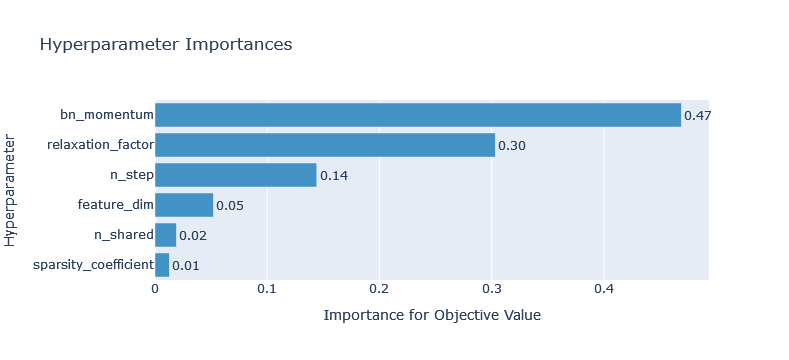

In [10]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
optuna.visualization.plot_param_importances(study)

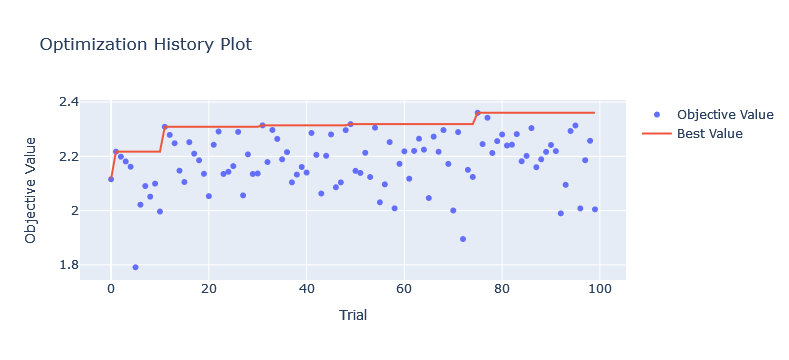

In [9]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
asdf

In [ ]:
def plot_history(model):
    hist = model.history
    for label, values in hist.history.items():
        if label.endswith('_auc'):
            plt.plot(values, label=label)

    plt.axhline(y=0.819, color='r', linestyle='--')
    plt.axhline(y=0.792, color='orange', linestyle='--')
    plt.axhline(y=0.835, color='g', linestyle='--')
    plt.legend(loc='lower right')  # Display the legend (labels)
    plt.show()  # Display the plot

In [ ]:
# do plane tabnet training
# here we use default value

from pytorch_tabnet.tab_model import TabNetClassifier

classifier = TabNetClassifier(
    n_d=8, # 8~64
    n_a=8, #  ==n_d
    n_steps=3, # 3~10
    n_independent=2, # 1~5
    n_shared = 2, #1~5
    optimizer_fn=torch.optim.Adam, # default
    optimizer_params=dict(lr=1e-2),
    scheduler_fn = None,
    lambda_sparse = 1e-3,
    device_name = 'auto',
    mask_type='sparsemax'# "sparsemax", entmax
    #model_name
    )

classifier.fit(X_train=flat_x[0], y_train=y[0],
               eval_set=[(flat_x[0], y[0]), (flat_x[2], y[2]), (flat_x[3], y[3]), (flat_x[1], y[1])],
               eval_name=['train', 'test_icu', 'test_covid', 'valid'],
               eval_metric=['auc'],
               max_epochs=50,
               patience=10,
               weights=0, # 0 no sample / 1 --> sampling considering class weight
               # loss = CE
               batch_size=1024,
               virtual_batch_size=128,
               num_workers = 8, # number of workers used in torch dataloader
               drop_last= False,
               callbacks=None,
               #pretraining_ratio  for pretrainer only
               )
plot_history(classifier)

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.16667 | train_auc: 0.76083 | test_icu_auc: 0.68754 | test_covid_auc: 0.80347 | valid_auc: 0.76045 |  0:00:49s
epoch 1  | loss: 0.14986 | train_auc: 0.76783 | test_icu_auc: 0.68598 | test_covid_auc: 0.73723 | valid_auc: 0.76438 |  0:01:37s
epoch 2  | loss: 0.14728 | train_auc: 0.78156 | test_icu_auc: 0.71073 | test_covid_auc: 0.82782 | valid_auc: 0.77565 |  0:02:25s
epoch 3  | loss: 0.14523 | train_auc: 0.79038 | test_icu_auc: 0.7155  | test_covid_auc: 0.78204 | valid_auc: 0.78092 |  0:03:14s
epoch 4  | loss: 0.14296 | train_auc: 0.80248 | test_icu_auc: 0.71279 | test_covid_auc: 0.7658  | valid_auc: 0.8018  |  0:04:03s


KeyboardInterrupt: 

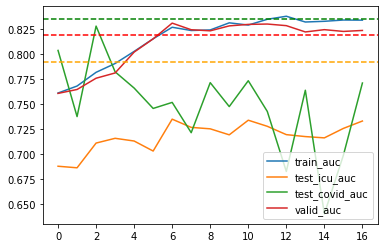

In [ ]:
plot_history(classifier)

In [ ]:
# change weight

classifier2 = TabNetClassifier(
    n_d=8, # 8~64
    n_a=8, #  ==n_d
    n_steps=3, # 3~10
    n_independent=2, # 1~5
    n_shared = 2, #1~5
    optimizer_fn=torch.optim.Adam, # default
    optimizer_params=dict(lr=1e-2),
    scheduler_fn = None,
    mask_type='sparsemax'# "sparsemax", entmax
    #model_name
    )

classifier2.fit(X_train=flat_x[0], y_train=y[0],
               eval_set=[(flat_x[0], y[0]), (flat_x[2], y[2]), (flat_x[3], y[3]), (flat_x[1], y[1])],
               eval_name=['train', 'test_icu', 'test_covid', 'valid'],
               eval_metric=['auc'],
               max_epochs=50,
               patience=10,
               weights=1, # 0 no sample / 1 --> sampling considering class weight
               # loss = CE
               batch_size=1024,
               virtual_batch_size=128,
               num_workers = 8, # number of workers used in torch dataloader
               drop_last= False,
               callbacks=None,
               #pretraining_ratio  for pretrainer only
               )
plot_history(classifier2)

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56299 | train_auc: 0.8055  | test_icu_auc: 0.72492 | test_covid_auc: 0.79415 | valid_auc: 0.79996 |  0:00:49s


KeyboardInterrupt: 

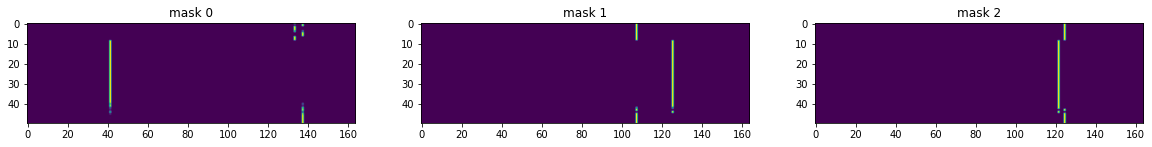

In [ ]:

explain_matrix, masks = classifier.explain(flat_x[1])

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

Hyperparameter search using optuna

In [ ]:
import optuna
from optuna import Trial, visualization

    # def __init__(
    #     self,
    #     num_features,
    #     feature_dim,
    #     output_dim,
    #     n_step = 2,
    #     n_total = 4,
    #     n_shared = 2,
    #     relaxation_factor = 1.5,
    #     bn_epsilon = 1e-5,
    #     bn_momentum = 0.7,
    #     sparsity_coefficient = 1e-5
    # ):
# classifier2 = TabNetClassifier(
#     n_d=8, # 8~64    == feature_dim
#     n_a=8, #  ==n_d   == num_features
#     gamma=1.3
#     n_steps=3, # 3~10
#     n_independent=2, # 1~5
#     n_shared = 2, #1~5
#     optimizer_fn=torch.optim.Adam, # default
#     optimizer_params=dict(lr=1e-2),
#     scheduler_fn = None,
#     lambda_sparse = 1e-3,
#     momentum = 0.02,
#     mask_type='sparsemax'# "sparsemax", entmax
#     #model_name
#     )

def Objective(trial):
    feature_dim = trial.suggest_categorical("n_d", [8,16,32, 64, 128])
    n_step = trial.suggest_int("n_step", 2, 9, step=1)
    n_shared = trial.suggest_int("n_shared", 0, 4, step=1)
    relaxation_factor = trial.suggest_float("gamma", 1., 3., step=0.1)
    sparsity_coefficient = trial.suggest_float("lambda_sparse", 0.00000001, 0.1, log=True)
    bn_momentum = trial.suggest_float('momentum', 0.9, 0.9999)
    tabnet_params = dict(num_features=flat_x[0].shape[1],
                         output_dim=feature_dim,
                         feature_dim=feature_dim,
                         n_step=n_step, 
                         relaxation_factor=relaxation_factor,
                         sparsity_coefficient=sparsity_coefficient,
                         n_shared = n_shared,
                         bn_momentum = bn_momentum
                     )
    class_weight =  trial.suggest_int("class_weight", 1, 10.5, step=0.5)
    
    cbs = [tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    
    tn = TabNetClassifier(**tabnet_params)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=10)
    loss = [tf.keras.losses.CategoricalCrossentropy(from_logits=False),None]
    
    tn.compile(
            optimizer,
            loss=loss)

    tn.fit(train_ds, 
          epochs=100, 
          validation_data=val_ds,
          callbacks=cbs,
          verbose=1)
    
    
    val_preds, _ =  tn.predict(val_ds)
    pr_auc = average_precision_score(val_y, val_preds[:,1])
    
    return pr_auc

study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, n_jobs=1, n_trials=100, gc_after_trial=True, show_progress_bar=True) 

IndentationError: unexpected indent (1084955490.py, line 4)